In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm  # tqdm是显示循环进度条的库


class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0  # 记录当前智能体位置的横坐标
        self.y = self.nrow - 1  # 记录当前智能体位置的纵坐标

    def step(self, action):  # 外部调用这个函数来改变当前位置
        # 4种动作, change[0]:上, change[1]:下, change[2]:左, change[3]:右。坐标系原点(0,0)
        # 定义在左上角
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False
        if self.y == self.nrow - 1 and self.x > 0:  # 下一个位置在悬崖或者目标
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done

    def reset(self):  # 回归初始状态,坐标轴原点在左上角
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x

In [3]:
class Sarsa:
    """ Sarsa算法 """
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])  # 初始化Q(s,a)表格
        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数

    def take_action(self, state):  # 选取下一步的操作,具体实现为epsilon-贪婪
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def best_action(self, state):  # 用于打印策略
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):  # 若两个动作的价值一样,都会记录下来
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    def update(self, s0, a0, r, s1, a1):
        td_error = r + self.gamma * self.Q_table[s1, a1] - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error

Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 5000.72it/s, episode=500, return=-18.900]


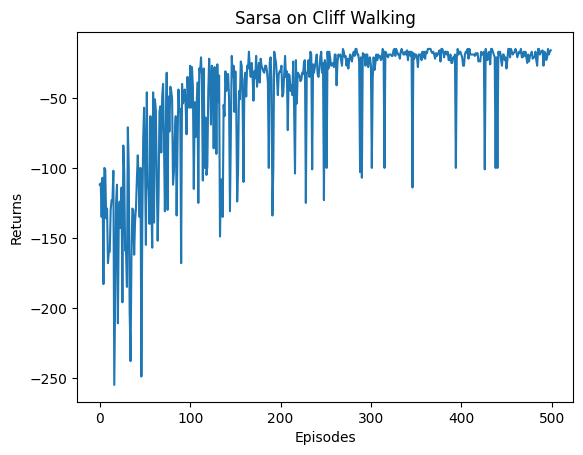

In [4]:
ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow)
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = Sarsa(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500  # 智能体在环境中运行的序列的数量

return_list = []  # 记录每一条序列的回报
for i in range(10):  # 显示10个进度条
    # tqdm的进度条功能
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False
            while not done:
                next_state, reward, done = env.step(action)
                next_action = agent.take_action(next_state)
                episode_return += reward  # 这里回报的计算不进行折扣因子衰减
                agent.update(state, action, reward, next_state, next_action)
                state = next_state
                action = next_action
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Sarsa on {}'.format('Cliff Walking'))
plt.show()

# Iteration 0: 100%|██████████| 50/50 [00:00<00:00, 1206.19it/s, episode=50,
# return=-119.400]
# Iteration 1: 100%|██████████| 50/50 [00:00<00:00, 1379.84it/s, episode=100,
# return=-63.000]
# Iteration 2: 100%|██████████| 50/50 [00:00<00:00, 2225.14it/s, episode=150,
# return=-51.200]
# Iteration 3: 100%|██████████| 50/50 [00:00<00:00, 2786.80it/s, episode=200,
# return=-48.100]
# Iteration 4: 100%|██████████| 50/50 [00:00<00:00, 1705.21it/s, episode=250,
# return=-35.700]
# Iteration 5: 100%|██████████| 50/50 [00:00<00:00, 3393.12it/s, episode=300,
# return=-29.900]
# Iteration 6: 100%|██████████| 50/50 [00:00<00:00, 3694.32it/s, episode=350,
# return=-28.300]
# Iteration 7: 100%|██████████| 50/50 [00:00<00:00, 3705.87it/s, episode=400,
# return=-27.700]
# Iteration 8: 100%|██████████| 50/50 [00:00<00:00, 4115.61it/s, episode=450,
# return=-28.500]
# Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 3423.20it/s, episode=500,
# return=-18.900]

In [4]:
def print_agent(agent, env, action_meaning, disaster=[], end=[]):
    for i in range(env.nrow):
        for j in range(env.ncol):
            if (i * env.ncol + j) in disaster:
                print('****', end=' ')
            elif (i * env.ncol + j) in end:
                print('EEEE', end=' ')
            else:
                a = agent.best_action(i * env.ncol + j)
                pi_str = ''
                for k in range(len(action_meaning)):
                    pi_str += action_meaning[k] if a[k] > 0 else 'o'
                print(pi_str, end=' ')
        print()


action_meaning = ['^', 'v', '<', '>']
print('Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

# Sarsa算法最终收敛得到的策略为：
# ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo
# ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo
# ^ooo ooo> ^ooo ooo> ooo> ooo> ooo> ^ooo ^ooo ooo> ooo> ovoo
# ^ooo **** **** **** **** **** **** **** **** **** **** EEEE

Sarsa算法最终收敛得到的策略为：
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo ooo> ^ooo ooo> ooo> ooo> ooo> ^ooo ^ooo ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 1092.57it/s, episode=500, return=-19.100]


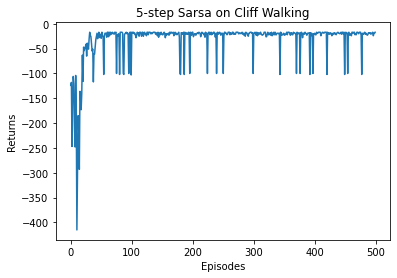

In [5]:
class nstep_Sarsa:
    """ n步Sarsa算法 """
    def __init__(self, n, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])
        self.n_action = n_action
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.n = n  # 采用n步Sarsa算法
        self.state_list = []  # 保存之前的状态
        self.action_list = []  # 保存之前的动作
        self.reward_list = []  # 保存之前的奖励

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def best_action(self, state):  # 用于打印策略
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    def update(self, s0, a0, r, s1, a1, done):
        self.state_list.append(s0)
        self.action_list.append(a0)
        self.reward_list.append(r)
        if len(self.state_list) == self.n:  # 若保存的数据可以进行n步更新
            G = self.Q_table[s1, a1]  # 得到Q(s_{t+n}, a_{t+n})
            for i in reversed(range(self.n)):
                G = self.gamma * G + self.reward_list[i]  # 不断向前计算每一步的回报
                # 如果到达终止状态,最后几步虽然长度不够n步,也将其进行更新
                if done and i > 0:
                    s = self.state_list[i]
                    a = self.action_list[i]
                    self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])
            s = self.state_list.pop(0)  # 将需要更新的状态动作从列表中删除,下次不必更新
            a = self.action_list.pop(0)
            self.reward_list.pop(0)
            # n步Sarsa的主要更新步骤
            self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])
        if done:  # 如果到达终止状态,即将开始下一条序列,则将列表全清空
            self.state_list = []
            self.action_list = []
            self.reward_list = []


np.random.seed(0)
n_step = 5  # 5步Sarsa算法
alpha = 0.1
epsilon = 0.1
gamma = 0.9
agent = nstep_Sarsa(n_step, ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500  # 智能体在环境中运行的序列的数量

return_list = []  # 记录每一条序列的回报
for i in range(10):  # 显示10个进度条
    #tqdm的进度条功能
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
            episode_return = 0
            state = env.reset()
            action = agent.take_action(state)
            done = False
            while not done:
                next_state, reward, done = env.step(action)
                next_action = agent.take_action(next_state)
                episode_return += reward  # 这里回报的计算不进行折扣因子衰减
                agent.update(state, action, reward, next_state, next_action,
                             done)
                state = next_state
                action = next_action
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('5-step Sarsa on {}'.format('Cliff Walking'))
plt.show()

# Iteration 0: 100%|██████████| 50/50 [00:00<00:00, 937.03it/s, episode=50,
# return=-26.500]
# Iteration 1: 100%|██████████| 50/50 [00:00<00:00, 2955.94it/s, episode=100,
# return=-35.200]
# Iteration 2: 100%|██████████| 50/50 [00:00<00:00, 2978.95it/s, episode=150,
# return=-20.100]
# Iteration 3: 100%|██████████| 50/50 [00:00<00:00, 3062.61it/s, episode=200,
# return=-27.200]
# Iteration 4: 100%|██████████| 50/50 [00:00<00:00, 3172.36it/s, episode=250,
# return=-19.300]
# Iteration 5: 100%|██████████| 50/50 [00:00<00:00, 3123.41it/s, episode=300,
# return=-27.400]
# Iteration 6: 100%|██████████| 50/50 [00:00<00:00, 2875.33it/s, episode=350,
# return=-28.000]
# Iteration 7: 100%|██████████| 50/50 [00:00<00:00, 2262.18it/s, episode=400,
# return=-36.500]
# Iteration 8: 100%|██████████| 50/50 [00:00<00:00, 3100.00it/s, episode=450,
# return=-27.000]
# Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 3107.54it/s, episode=500,
# return=-19.100]

In [6]:
action_meaning = ['^', 'v', '<', '>']
print('5步Sarsa算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

# 5步Sarsa算法最终收敛得到的策略为：
# ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo
# ^ooo ^ooo ^ooo oo<o ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ovoo
# ooo> ^ooo ^ooo ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ooo> ovoo
# ^ooo **** **** **** **** **** **** **** **** **** **** EEEE

5步Sarsa算法最终收敛得到的策略为：
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo ^ooo ^ooo oo<o ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ovoo 
ooo> ^ooo ^ooo ^ooo ^ooo ^ooo ^ooo ooo> ooo> ^ooo ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 1112.17it/s, episode=500, return=-61.700]


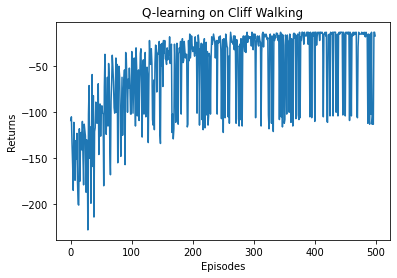

Q-learning算法最终收敛得到的策略为：
^ooo ovoo ovoo ^ooo ^ooo ovoo ooo> ^ooo ^ooo ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ^ooo ooo> ooo> ooo> ooo> ovoo 
ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo 
^ooo **** **** **** **** **** **** **** **** **** **** EEEE 


In [7]:
class QLearning:
    """ Q-learning算法 """
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])  # 初始化Q(s,a)表格
        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数

    def take_action(self, state):  #选取下一步的操作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])
        return action

    def best_action(self, state):  # 用于打印策略
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a

    def update(self, s0, a0, r, s1):
        td_error = r + self.gamma * self.Q_table[s1].max(
        ) - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_error


np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = QLearning(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500  # 智能体在环境中运行的序列的数量

return_list = []  # 记录每一条序列的回报
for i in range(10):  # 显示10个进度条
    # tqdm的进度条功能
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):  # 每个进度条的序列数
            episode_return = 0
            state = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done = env.step(action)
                episode_return += reward  # 这里回报的计算不进行折扣因子衰减
                agent.update(state, action, reward, next_state)
                state = next_state
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:  # 每10条序列打印一下这10条序列的平均回报
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Q-learning on {}'.format('Cliff Walking'))
plt.show()

action_meaning = ['^', 'v', '<', '>']
print('Q-learning算法最终收敛得到的策略为：')
print_agent(agent, env, action_meaning, list(range(37, 47)), [47])

# Iteration 0: 100%|██████████| 50/50 [00:00<00:00, 1183.69it/s, episode=50,
# return=-105.700]
# Iteration 1: 100%|██████████| 50/50 [00:00<00:00, 1358.13it/s, episode=100,
# return=-70.900]
# Iteration 2: 100%|██████████| 50/50 [00:00<00:00, 1433.72it/s, episode=150,
# return=-56.500]
# Iteration 3: 100%|██████████| 50/50 [00:00<00:00, 2607.78it/s, episode=200,
# return=-46.500]
# Iteration 4: 100%|██████████| 50/50 [00:00<00:00, 3007.19it/s, episode=250,
# return=-40.800]
# Iteration 5: 100%|██████████| 50/50 [00:00<00:00, 2005.77it/s, episode=300,
# return=-20.400]
# Iteration 6: 100%|██████████| 50/50 [00:00<00:00, 2072.14it/s, episode=350,
# return=-45.700]
# Iteration 7: 100%|██████████| 50/50 [00:00<00:00, 4244.04it/s, episode=400,
# return=-32.800]
# Iteration 8: 100%|██████████| 50/50 [00:00<00:00, 4670.82it/s, episode=450,
# return=-22.700]
# Iteration 9: 100%|██████████| 50/50 [00:00<00:00, 4705.19it/s, episode=500,
# return=-61.700]

# Q-learning算法最终收敛得到的策略为：
# ^ooo ovoo ovoo ^ooo ^ooo ovoo ooo> ^ooo ^ooo ooo> ooo> ovoo
# ooo> ooo> ooo> ooo> ooo> ooo> ^ooo ooo> ooo> ooo> ooo> ovoo
# ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ooo> ovoo
# ^ooo **** **** **** **** **** **** **** **** **** **** EEEE